# Sediment correction of the Neuquen basin

Sediment correction for the gravity data


## Package imports

In [1]:
%matplotlib inline

from __future__ import division
import datetime
import numpy as np
import matplotlib.pyplot as plt                 
from mpl_toolkits.basemap import Basemap        
import multiprocessing
import seaborn  # Makes the default style of the plots nicer

# The computations generate a lot of run-time warnings.
# They aren't anything to be concerned about so disable them to avoid clutter.
import warnings
warnings.simplefilter('ignore')

# Load the required modules from Fatiando a Terra.
from fatiando.gravmag import tesseroid, normal_gravity
from fatiando import gridder, utils
import fatiando

# Load our custom classes and functions.
from mohoinv import TesseroidRelief, make_mesh
from datasets import load_icgem_gdf, down_sample        

# Get the number of cores in this computer to run the some things in parallel.
ncpu = multiprocessing.cpu_count()
print("Number of cores: {}".format(ncpu))

Number of cores: 8


## Load and plot the raw data

###  Load the sediment thickness data

In [2]:
# Sediment data
lat_s, lon_s, s = np.loadtxt('../data/sediment_thickness.txt', unpack=True)
z_s = -s.copy()
lon_s = lon_s

# Define the area and shape
area_s = (lat_s.min(), lat_s.max(), lon_s.min(), lon_s.max())
print area_s
print lat_s.size
print lon_s.size
print z_s.size
shape_s = (117, 91)

(-40.149999999999999, -34.350000000000001, 289.14999999999998, 293.64999999999998)
10647
10647
10647


### Load the gravity data

In [4]:
# Gravity data (latitude lonitude height_of_medition gravitydisturbance topography_effect bouguer_anomaly)
# Model 1
lat, lon, h_1, g_1, disturbance_1, topo_effect_1, bouguer_1 = np.loadtxt('../data/processed-eigen-6c4-gravity-2190-10km.txt', unpack=True)

# Model 2
lat, lon, h_2, g_2, disturbance_2, topo_effect_2, bouguer_2 = np.loadtxt('../data/processed-eigen-6c4-gravity-370-55km.txt', unpack=True)


In [5]:
# Define the area and shape
area_g = (lat.min(), lat.max(), lon.min(), lon.max())
print area_g

shape_g = ((lat.max()-lat.min())/0.05 + 1, (lon.max()-lon.min())/0.05 + 1)
print shape_g

(-41.0, -34.0, 285.0, 295.0)
(141.0, 201.0)


In [6]:
# Setup a basemap to plot the sediment thickness data with an appropriate projection.
bm = Basemap(projection='merc', 
             llcrnrlon=area_g[2], urcrnrlon=area_g[3], 
             llcrnrlat=area_g[0], urcrnrlat=area_g[1],
             lon_0=0.5*(area_g[2] + area_g[3]), lat_0=0.5*(area_g[1] + area_g[0]), 
             resolution='l')

# Make a plotting function to avoid repeating this code.
def plot_data(lat, lon, data, shape, cmap, cblabel='mGal', levels=60, ranges=True):
    x, y = bm(lon, lat) # Transform lat and lon into plot coordinates
    kwargs = dict(cmap=cmap)
    if ranges:
        ranges = np.abs([data.min(), data.max()]).max()
        kwargs['vmin'] = -ranges
        kwargs['vmax'] = ranges
    fig = plt.figure(figsize=(7, 6))
    bm.contourf(x.reshape(shape), y.reshape(shape), data.reshape(shape), levels, 
                **kwargs)
    plt.colorbar(pad=0.01, aspect=50).set_label(cblabel)
    bm.drawmeridians(np.arange(area_g[2], area_g[3], 2), labels=[False, False, False, True])
    bm.drawparallels(np.arange(area_g[0], area_g[1], 2), labels=[True, False, False, False])
    bm.drawcoastlines()
    bm.drawcountries()
    bm.drawstates()
    plt.tight_layout(pad=0)
    return fig

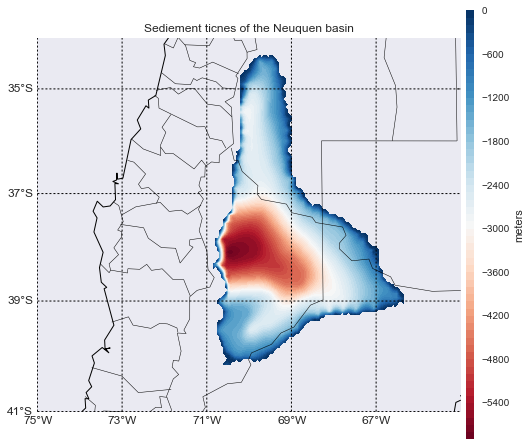

In [7]:
# Plot the raw sediment thickness data.
plot_data(lat_s, lon_s, z_s, shape_s, 'RdBu', cblabel='meters', ranges=False)
plt.title('Sediement ticnes of the Neuquen basin')

## Remove the effect of sediments

Respecto a los contrastes de densidad (ρ) sedimentos-basamento, en su forma sencilla de cálculo se puede asignar un contraste isótropo y homogéneo para toda la cuenca del orden de +0,35 +0,40 g /cm3 (ρs 2,35 y ρb 2,70-2,75 g/cm3, donde ρs y ρb son las densidades asignadas a los sedimentos y al basamento respectivamente), lo cual es una simplificación que no toma en cuenta ni los cambios de espesor total de la columna sedimentaria ni sus contrastes litológicos, que pueden provocar inhomogeneidades laterales de densidad y anisotropía en las velocidades de propagación de ondas sísmicas en presencia de grandes intervalos de lutitas (Fm. Vaca Muerta) por ejemplo.

Conceptualmente entonces, estamos en condiciones de señalar que si bien los contrastes de densidad sedimentos-basamento tienden a ser cada vez menores en valor absoluto a medida que nos acercamos al centro de cuenca, y su rango de variación está en el orden de 0,275 g/cm3 a 0,412 g/cm3, sin embargo, la corrección del efecto del relleno sedimentario en la anomalía de Bouguer siempre tenderá a ser mayor a medida que la columna sedimentaria es más espesa (Figura 3.7) por una combinación de efectos deaumento promedio tanto de h_S como ρ_S.


Now we need to set a density value for the sediment. We'll use the standard 2350 kg/m³ for the sediment and 2725 kg/m3 for basament. Therefore the contrast is -375 kg/m3.

In [8]:
z_s[np.isnan(z_s)] = 0.
print z_s

sediment_model = make_mesh(area_s, shape_s, z_s, reference=0) 
print sediment_model.relief

print h_1, h_2


[ 0.  0.  0. ...,  0.  0.  0.]
[ 0.  0.  0. ...,  0.  0.  0.]
[ 10000.  10000.  10000. ...,  10000.  10000.  10000.] [ 55000.  55000.  55000. ...,  55000.  55000.  55000.]


In [9]:
# Density in the basin
contrast_density = -375*np.ones(sediment_model.size)
sediment_model.addprop('density', contrast_density)


Forward model the effect of the topography in spherical coordinates using tesseroids. Use all available cores for this calculation. It will take a while.

In [10]:
# Model 1
%time sediment_effect_1 = tesseroid.gz(lon, lat, h_1, sediment_model, njobs=ncpu)


CPU times: user 28 ms, sys: 24 ms, total: 52 ms
Wall time: 23.5 s


In [11]:
# Model 2
%time sediment_effect_2 = tesseroid.gz(lon, lat, h_2, sediment_model, njobs=ncpu)


CPU times: user 24 ms, sys: 36 ms, total: 60 ms
Wall time: 22.5 s


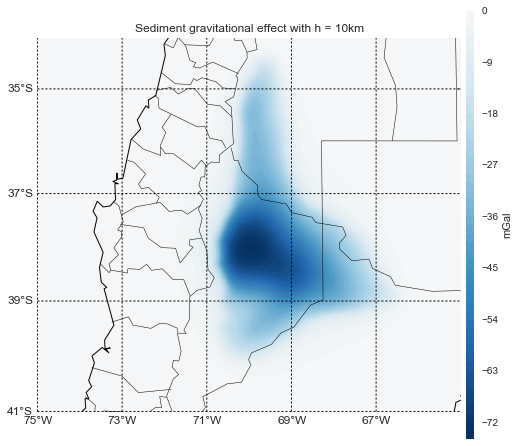

In [14]:
plot_data(lat, lon, sediment_effect_1, shape_g, cmap='RdBu_r')
plt.title('Sediment gravitational effect with h = 10km')

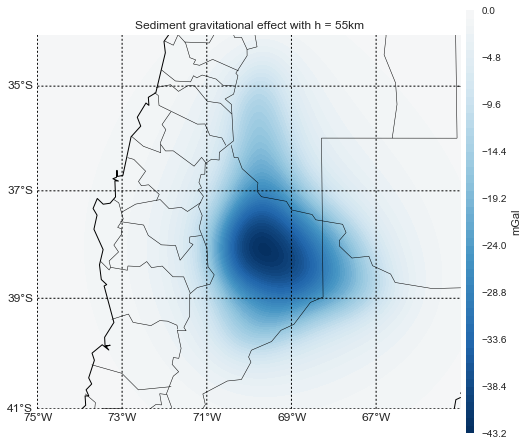

In [13]:
plot_data(lat, lon, sediment_effect_2, shape_g, cmap='RdBu_r')
plt.title('Sediment gravitational effect with h = 55km')

Calculation of Sediment-free Bouguer anomaly

In [15]:
# Model 1
sedfree_bouguer_1 = bouguer_1 - sediment_effect_1

In [16]:
# Model 2
sedfree_bouguer_2 = bouguer_2 - sediment_effect_2

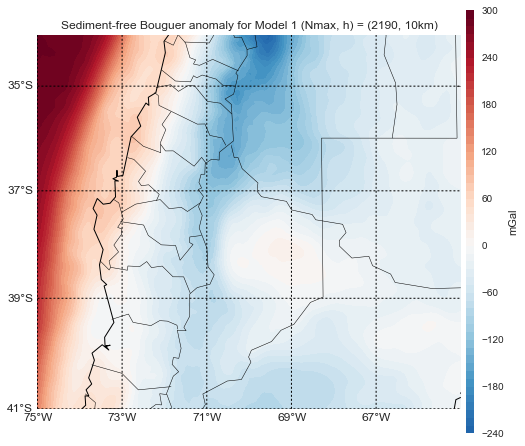

In [17]:
plot_data(lat, lon, sedfree_bouguer_1, shape_g, cmap='RdBu_r')
plt.title('Sediment-free Bouguer anomaly for Model 1 (Nmax, h) = (2190, 10km)')

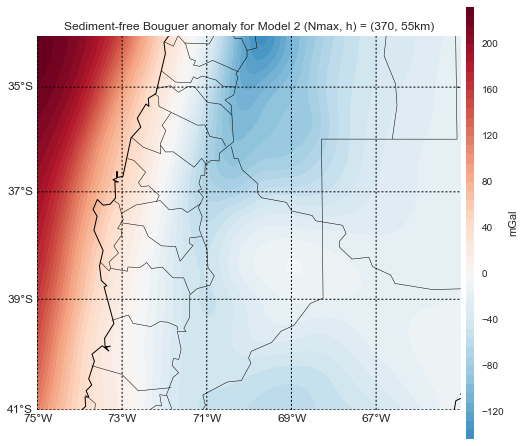

In [18]:
plot_data(lat, lon, sedfree_bouguer_2, shape_g, cmap='RdBu_r')
plt.title('Sediment-free Bouguer anomaly for Model 2 (Nmax, h) = (370, 55km)')

## Save the data

In [20]:
header = '\n'.join(["# Generated sedoment-correction-of-Neuquen-basin.ipynb",
                    "# Data: EIGEN-6C4-gravity-2190-10km.gdf and sediment_thickness.txt",
                    "# latitude lonitude height_of_medition bouguer_anomaly" + \
                    "sediment_effect_of_neuquen_basin sedfree_bouguer"
                   ])
with open('../data/sedfree-bouguer-eigen-6c4-gravity-2190-10km.txt', 'w') as f:
    f.write(header)
    np.savetxt(f, np.c_[lat, lon, h_1, bouguer_1, sediment_effect_1, sedfree_bouguer_1], fmt='%.5f')

In [21]:
header = '\n'.join(["# Generated sedoment-correction-of-Neuquen-basin.ipynb",
                    "# Data: EIGEN-6C4-gravity-370-55km.gdf and sediment_thickness.txt",
                    "# latitude lonitude height_of_medition bouguer_anomaly" + \
                    "sediment_effectt_of_neuquen_basin sedfree_bouguer"
                   ])
with open('../data/sedfree-bouguer-eigen-6c4-gravity-3700-55km.txt', 'w') as f:
    f.write(header)
    np.savetxt(f, np.c_[lat, lon, h_2, bouguer_2, sediment_effect_2, sedfree_bouguer_2], fmt='%.5f')